In [190]:
"""
Convole script:

1) Read data from all 7 sectors
2) Split up into chunks based on cmd line input
3) Write partial results
4) If time, make faster
tess_dir="/home/ctaiudovicic/projects/tess_batman/sampleData/"
# tess_dir="/home/cjtu/projects/tess_batman/sampleData/"
batman_dir="/home/ctaiudovicic/projects/tess_batman/data/"
sector=0
start=5
end=15
output_dir= "/home/ctaiudovicic/projects/tess_batman/data/tmp/"
verbosity=0
"""
!python convolve.py ~/projects/tess_batman/sampleData/ ~/projects/tess_batman/data/ 0 0 2 ~/projects/tess_batman/data/tmp/

===START TCONVOLVE===
Reading TESS data...
Found 2 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...
Convolved 2560 curves in 1.21 s
Found: 10 fitting curves
Writing table: candidates_s0_b0_e2_HD_1397_b.fits.csv
Finished TESS file in 1.22 s
Starting TESS file: HD_202772_A_b.fits
Starting convolutions...
Convolved 2560 curves in 1.18 s
Found: 10 fitting curves
Writing table: candidates_s0_b0_e2_HD_202772_A_b.fits.csv
Finished TESS file in 1.2 s
Convolved 2/2 tess files with 2560 curves in 2.62 s
===END TCONVOLVE===


In [182]:
import time
import glob
import os.path as p
import numpy as np
from scipy.signal import fftconvolve
from astropy.io import ascii, fits
from astropy.table import Table, Column


def tconvolve(tess_dir, batman_dir, sector, start, end, output_dir, verbosity=0):
    """
    
    Parameters
    ----------
    tess_dir(str): directory to TESS data
    batman_dir (str): directory to model data
    sector (int): sector to pull data from
    start (int): file to start at
    end (int): file to end at
    output_dir (str): directory to write candidates.csv
    """
    tconv_start = time.time()
    print("===START TCONVOLVE===")
    
    # Handle relative paths
    tess_dir = p.abspath(tess_dir)
    batman_dir = p.abspath(batman_dir)
    output_dir = p.abspath(output_dir)
    
    # Read in TESS Sector data
    print("Reading TESS data...")
    sector_name = "Sector{}".format(sector)
    if sector == 0:
        sector_name = "sample_"+sector_name
    sector_path = p.join(tess_dir, sector_name)
    sector_files = glob.glob(p.join(sector_path,"*.fits"))
    tess_names = sector_files[start:end]
    ntess = len(tess_names)
    print("Found {} TESS files to process".format(ntess))

    # Read in Batman Curves 
    print("Reading Batman transit curves...")
    batmanCurves = ascii.read(p.join(batman_dir,"batmanCurves_small.csv"), 
                       data_start=1, format='csv')
    times = np.array(batmanCurves['times'])
    curve_names = np.array(batmanCurves.colnames[1:])
    nbatman = len(curve_names)
    print("Found {} Batman curves".format(nbatman))
    
    nerr = 0  # count number of failed files
    # Do convolution on all tess files
    for tess_fpath in tess_names:
        tess_fname = p.basename(tess_fpath)
        print("Starting TESS file: {}".format(tess_fname))
        tess_start = time.time()

        try:
            with fits.open(tess_fpath, mode="readonly") as hdulist:
                hdr = hdulist[0].header
                tess_time = hdulist[1].data['TIME']
                tess_flux = hdulist[1].data['PDCSAP_FLUX']
        except Exception as e: 
            print("ERROR reading file: ", tess_fpath, " with error: ", e)
            nerr += 1
            continue  # skip to next loop iter
        
        # clean tess lightcurve of nans
        med = np.nanmedian(tess_flux)
        tess_flux[np.isnan(tess_flux)] = med
        
        tmean = np.mean(tess_flux)
        tstd = np.std(tess_flux)
        tess_flux = (tess_flux - tmean)/tstd
        
        # Do convolution on each batman curve
        peak_times = np.zeros(nbatman)
        peak_convs = np.zeros(nbatman)
        conv_start = time.time()
        print("Starting convolutions...")
        for i, curvename in enumerate(curve_names):
            # run convolution
            # new way
            batman_curve = batmanCurves[curvename]
            conv = np.abs(fftconvolve(tess_flux, batman_curve, 'same'))
            ind_max = np.argmax(convolution)
            peak_times[i] = tess_time[ind_max]
            peak_convs[i] = conv[ind_max]
                                  


        conv_time = time.time() - conv_start
        print("Convolved {} curves in {:.3} s".format(nbatman, conv_time))
        
        # Keep 10 best curves
        idxs = peak_convs.argsort()[-10:]
        convs = peak_convs[idxs]
        times = peak_times[idxs]
        curves = curve_names[idxs]
        nfitcurves = len(curves)
        print("Found: {} fitting curves".format(nfitcurves))
        
        # Make table
        if nfitcurves > 0:
            outname = 'candidates_s{}_b{}_e{}_{}.csv'.format(sector,start,end,tess_fname)
            outpath = p.join(output_dir, outname)
            print("Writing table: {}".format(outname))
            candidates = Table()
            candidates.add_column(Column([sector_name]*nfitcurves), name="sector")
            candidates.add_column(Column([tess_fname]*nfitcurves), name="tessFile")
            candidates.add_column(Column(curves), name="curveID")
            candidates.add_column(Column(times), name="tcorr")
            candidates.add_column(Column(convs), name="correlation")

            ascii.write(candidates, outpath, format='csv', overwrite=True, comment='#')
            tess_time = time.time() - tess_start
        else:
            print("No curves found for {}, Skipping write...".format(tess_fname))
        print("Finished TESS file in {:.3} s".format(tess_time))
    
    tconv_time = time.time() - tconv_start
    print("Convolved {}/{} tess files and {} curves in {:.3} s".format(ntess-nerr, ntess, nbatman, tconv_time))
    print("===END TCONVOLVE===")
    
def main():
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument("tess_dir", type=str)
    parser.add_argument("batman_dir", type=str)
    parser.add_argument("sector", type=int)
    parser.add_argument("start", type=int)
    parser.add_argument("end", type=int)
    parser.add_argument("output_dir", type=str)
    parser.add_argument("-v", "--verbosity", default=False, 
                        action="store_true", help="Print console output")
    args = parser.parse_args()
    tconvolve(args.tess_dir, args.batman_dir, args.sector, args.start, 
          args.end, args.output_dir, args.verbosity)
          
# if __name__ == '__main__':
#     main()

In [183]:
tess_dir="/home/ctaiudovicic/projects/tess_batman/sampleData/"
# tess_dir="/home/cjtu/projects/tess_batman/sampleData/"
batman_dir="/home/ctaiudovicic/projects/tess_batman/data/"
sector=0
start=5
end=15
output_dir= "/home/ctaiudovicic/projects/tess_batman/data/tmp/"
verbosity=0
tconvolve(tess_dir,batman_dir, sector, start, end, output_dir, verbosity=0)


===START TCONVOLVE===
Reading TESS data...
Found 5 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: tess2018263035959-s0003-0000000003836541-0123-s_lc.fits
Starting convolutions...
Convolved 2560 curves in 1.29 s
convs
Found: 10 fitting curves
Writing table: candidates_s0_b5_e15_tess2018263035959-s0003-0000000003836541-0123-s_lc.fits.csv
Finished tess file in 1.31 s
Starting TESS file: tess2018263035959-s0003-0000000003957254-0123-s_lc.fits
Starting convolutions...
Convolved 2560 curves in 1.25 s
convs
Found: 10 fitting curves
Writing table: candidates_s0_b5_e15_tess2018263035959-s0003-0000000003957254-0123-s_lc.fits.csv
Finished tess file in 1.27 s
Starting TESS file: tess2018349182459-s0006-0000000200319843-0126-s_lc.fits
Starting convolutions...
Convolved 2560 curves in 1.01 s
convs
Found: 10 fitting curves
Writing table: candidates_s0_b5_e15_tess2018349182459-s0006-0000000200319843-0126-s_lc.fits.csv
Finished tess file in 1.02 s
St

In [ ]:
""" Peak finder
# find convolution peaks above 99%
pct = np.percentile(conv, 99)
peak_idxs, cprops = sp.signal.find_peaks(conv, height=pct)
peak_time.append(tess_time[peak_idxs])
peak_conv.append(conv[peak_idxs])
peak_ind = np.argmax(peak_conv[-1])
peak_max.append(conv[peak_ind])
#  print("Pct:",pct, "Count:",len(peaks))
"""

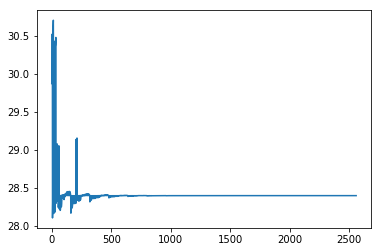

In [56]:
import matplotlib.pyplot as plt
# plt.plot(np.concatenate((arr[::-1],arr)))
plt.plot(n)

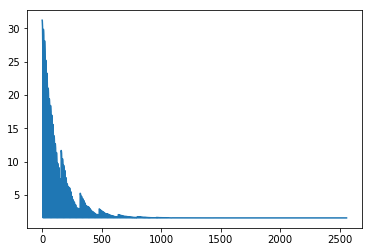

In [57]:
plt.plot(o*10)

In [62]:
# Read in TESS Sector data
print("Reading TESS data...")
sector_name = "Sector{}".format(sector)
if sector == 0:
    sector_name = "sample_"+sector_name
sector_path = p.join(tess_dir, sector_name)
sector_files = glob.glob(p.join(sector_path,"*.fits"))
tess_names = sector_files[start:end]
ntess = len(tess_names)
print("Found {} TESS files to process".format(ntess))

# Read in Batman Curves 
print("Reading Batman transit curves...")
batmanCurves = ascii.read(p.join(batman_dir,"batmanCurves_small.csv"), 
                   data_start=1, format='csv')
times = np.array(batmanCurves['times'])
curve_names = np.array(batmanCurves.colnames[1:])
nbatman = len(curve_names)
print("Found {} Batman curves".format(nbatman))

nerr = 0  # count number of failed files
# Do convolution on all tess files
tess_fpath = tess_names[0]
tess_fname = p.basename(tess_fpath)
print("Starting TESS file: {}".format(tess_fname))
tess_start = time.time()

try:
    with fits.open(tess_fpath, mode="readonly") as hdulist:
        hdr = hdulist[0].header
        tess_time = hdulist[1].data['TIME']
        tess_flux = hdulist[1].data['PDCSAP_FLUX']
except Exception as e: 
    print("ERROR reading file: ", tess_fpath, " with error: ", e)
    nerr += 1
    #continue  # skip to next loop iter

# clean tess lightcurve of nans
med = np.nanmedian(tess_flux)
tess_flux[np.isnan(tess_flux)] = med

tmean = np.mean(tess_flux)
tstd = np.std(tess_flux)
tess_flux = (tess_flux - tmean)/tstd
# Do convolution on each batman curve
max_array=np.zeros(nbatman)
tmax_array=np.zeros(nbatman)
conv_start = time.time()
print("Starting convolutions...")
j = 0
curvename = curve_names[0]

batman_flux = batmanCurves[curvename]
convolution = np.abs(np.convolve(tess_flux, batman_flux, 'same'))

Reading TESS data...
Found 10 TESS files to process
Reading Batman transit curves...
Found 2560 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...


In [64]:
batman_flux_nopad = batmanCurves[curvename]
len_diff = len(tess_time)-len(batman_flux_nopad)
batman_flux = np.pad(batman_flux_nopad, (len_diff, 0), 'constant', constant_values=(1,1))      
batman_FFT=np.fft.fft(batman_flux)
tess_FFT=np.fft.fft(tess_flux)
convolution2=(np.absolute(np.fft.ifft((batman_FFT)*(tess_FFT))))

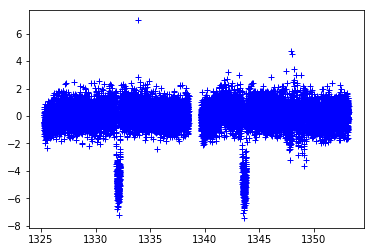

In [10]:
plt.plot(tess_time,tess_flux, 'b+')

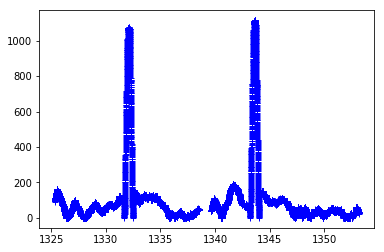

In [67]:
plt.plot(tess_time,convolution, 'b+')


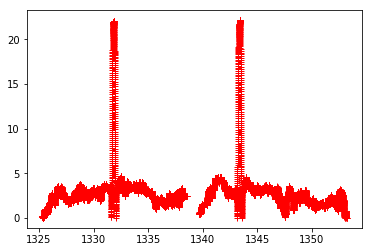

In [66]:
plt.plot(tess_time,convolution2, 'r+')

In [27]:
import scipy as sp


Pct: 1064.259000340717 Count: 39


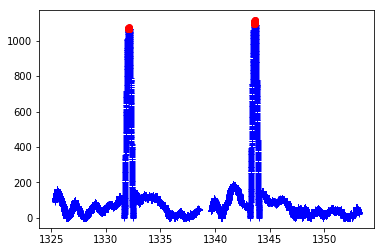

In [37]:
pct=np.percentile(convolution, 99)
peaks,props=sp.signal.find_peaks(convolution,height=pct)
print("Pct:",pct, "Count:",len(peaks))
plt.plot(tess_time,convolution, 'b+')
plt.plot(tess_time[peaks],convolution[peaks], 'ro')

In [184]:
a = [1,2,3]
print(a[:1000])

[1, 2, 3]
